# Creating Spectrograms: Wideband and Narrowband
## 2018 Jan 17
## ECE590sip Spectrogram Reading Seminar
Edited on 1/17/2018


First things first.
* Download Praat from http://www.fon.hum.uva.nl/praat/.  Praat is by far the fastest way to put a good quality, readable spectrogram on your screen.  During this entire seminar series, I will usually use Praat to create really readable spectrograms.

* Download python3 including Jupyter notebook, e.g., from https://www.anaconda.com/download/.  Python can create good quality spectrograms, but Jupyter destroys them by displaying them in little tiny in-line figures -- nevertheless I'll use Jupyter, in order to make it easy to show you how the basic code works.

* In fact you can probably use any python interface; nothing I'm doing is really specific to anaconda.


* You will need pysoundfile.  In the Windows anaconda distribution, you get this by opening an "Anaconda Prompt" window, then typing "pip install pysoundfile".  Then restart your python command window.


### Basics of python
* If you don't know python, you should learn.  Open https://docs.python.org/3/tutorial/, and take the first few tutorial pages.
* Python can be run directly in a web browser, using Jupyter.
* Python can be run in interpreted mode, using an interpreted window like Spyder or ipython.
* This page has two versions: an IPYNB version, and an HTML version.  If you're looking at the HTML version, then you can cut and paste code from this page into some other python window (e.g., Spyder) in order to run it.  If you're looking at the IPYNB version of this page, then you can run any individual code window by putting your cursor into that window, and by pressing "Shift-Enter."
* The next window is an example of a code window.  The next window imports several libraries that will be useful for us.

In [1]:
import soundfile as sf   # We use this one to read and write sound file
import math # basic math functions
import io # We use this one for basic file input/output operations
import numpy as np   # We use this one to do numerical operations
import scipy.fftpack as fftpack # We use this one to perform Fourier transforms
import urllib.request as request  # We use this one to get things from the web
import matplotlib.pyplot as plt  # We use this one to plot things
# The next line causes matplotlib to put its plots in this webpage.  That's reasonable for small spectrograms, maybe less than one second.
%matplotlib inline

## Plotting a waveform
The first thing we want to do is download two waveforms from the internet, plot them, and then choose 1-second chunks to work with.  We will explore many sources of audio in this course.  Today, let's get our audio from Project Gutenberg.  We'll download the first part of "Pride and Prejudice" (read by a female speaker), and the first part of "White Fang".  We'll use urllib.request to download each file, then soundfile to load the audio and sampling frequency (fs), following the examples on the page https://pypi.python.org/pypi/PySoundFile/0.8.1
* Note: both of these files are OGG Vorbis audio format.  Python soundfile works fine with OGG, WAV, and FLAC, but doesn't work with MP3.  If you want to use MP3 files, you'll have to use some other more complicated Python library, and/or convert them before reading them in.

In [2]:
# First, "Pride and Prejudice".  I found the following URL by going to gutenberg.org, searching for "Pride and Prejudice," 
# clicking on the audio version, then copying the URL from the first "OGG Vorbis Audio" file
p_url = 'http://www.gutenberg.org/files/26301/ogg/26301-01.ogg'
p_data, p_fs = sf.read(io.BytesIO(request.urlopen(p_url).read()))
# Now, "White Fang".  
w_url = 'http://www.gutenberg.org/files/23976/ogg/23976-01.ogg'
w_data, w_fs = sf.read(io.BytesIO(request.urlopen(w_url).read())) 
# Let's save both of those files in the current directory, so we can read them using other programs
# Let's save them as WAV; it's a big file, but can be opened by a wider variety of programs
sf.write('pride_and_prejudice_part1.wav',p_data,p_fs)
sf.write('white_fang_part1.wav',w_data,w_fs)

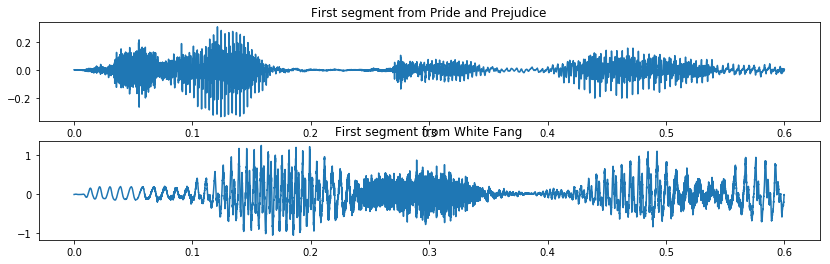

In [3]:
# Afer opening each file in Praat, we discover that
# the speech part of "Pride and Prejudice" starts at about t=0.74s 
# and the speech part of "White Fang" starts at about t=0.42s
# Let's cut out an 0.6s segment from each, and plot them
p_wav = p_data[int(0.74*p_fs):int((0.74+0.6)*p_fs)]
w_wav = w_data[int(0.42*w_fs):int((0.42+0.6)*w_fs)]  #############################
# We'll use the numpy function "linspace" to create a time axis for plotting
p_timeaxis = np.linspace(0,0.6,len(p_wav))
w_timeaxis = np.linspace(0,0.6,len(w_wav))
# And plot them
f1=plt.figure(1,figsize=(14,4))
plt.subplot(211)
plt.plot(p_timeaxis,p_wav)
plt.title('First segment from Pride and Prejudice')
plt.subplot(212)
plt.plot(w_timeaxis,w_wav)
plt.title('First segment from White Fang')

## Creating a spectrogram

There are three logically distinct functions required to create a spectrogram: enframing the audio, computing the STFT, and computing the power level.  We will create three separate python functions for those.

### 1. Enframe the audio
First, we chop the audio into frames, and multiply by a window.  The $n^{th}$ sample of the $t^{th}$ frame is
$$x_t[n] = w[n] x[n-tS]$$
where $x[n]$ is the original input audio signal, and $w[n]$ is a window.  The window length is $L$, i.e., it's defined for samples $w[0]$ through $w[L-1]$.   Usually, it's tapered but symmetric, so that $w[n]=w[L-1-n]$.  Windows that fit this description include the Hamming, Hannning, Gaussian, and triangular (Bartlett) windows, among others.  For example, the Hamming window is 
$$w[n] = 0.54 - 0.46\cos\left(\frac{2\pi n}{L-1}\right)$$

The inputs to the enframe functions are the signal $x[n]$, the window skip parameter $S$, and the window length $L$.  The output is a list of frames.



In [4]:
def enframe(x,S,L):
   # w = 0.54*np.ones(L)
    #for n in range(0,L):
     #   w[n] = w[n] - 0.46*math.cos(2*math.pi*n/(L-1))
    w = np.hamming(L)
    frames = []
    nframes = 1+int((len(x)-L)/S)
    for t in range(0,nframes):
        frames.append(np.copy(x[(t*S):(t*S+L)])*w)
    return(frames)

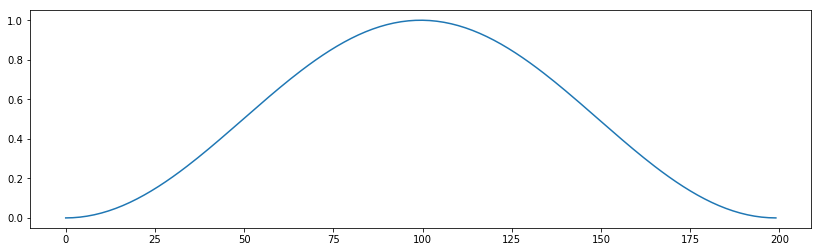

In [5]:
w = np.hanning(200)
f2 = plt.figure(figsize=(14,4))
plt.plot(w)

Test it by generating frames from w_wav and p_wav, and show the twelfth frame of each.  We'll use a 35ms window and 10ms skip for now, though that's not appropriate for spectrograms!

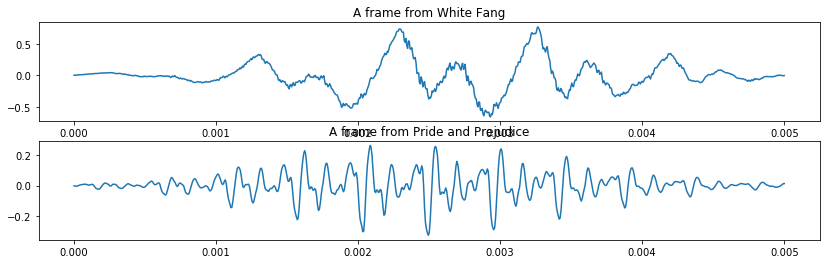

In [6]:
w_frames = enframe(w_wav,int(0.01*w_fs),int(0.035*w_fs))
p_frames = enframe(p_wav,int(0.01*p_fs),int(0.035*p_fs))
plt.figure(figsize=(14,4))
plt.subplot(211)
plt.plot(np.linspace(0,0.005,len(w_frames[11])),w_frames[11])
plt.title('A frame from White Fang')
plt.subplot(212)
plt.plot(np.linspace(0,0.005,len(p_frames[11])),p_frames[11])
plt.title('A frame from Pride and Prejudice')

### 2. Create STFT from the frames
Short-time Fourier transform is created by taking the Fourier transform of each frame:
$$X_t(f) = \sum_{n=0}^{L-1} x_t[n] e^{-j2\pi fn/F_s}$$
We calculate this at $N$ different frequencies, $f_k = \frac{F_s k}{N}$, for $0\le k\le N-1$.   

The inputs to the stft function are the set of frames, the fft length $N$, and the sampling frequency $F_s$.

The outputs are the STFT (the set of Fourier-transformed frames), and the corresponding frequency axis.  We create the frequency axis by just using the linspace command to generate a list of the frequencies, in Hertz, for each of the $N$ frequency samples.

In [7]:
def stft(frames,N,Fs):
    stft_frames = [ fftpack.fft(x,N) for x in frames]
    freq_axis = np.linspace(0,Fs,N)
    return(stft_frames, freq_axis)

Test it: compute the stft of each of the inputs, then show the magnitude-squared STFT of the twelfth frame.

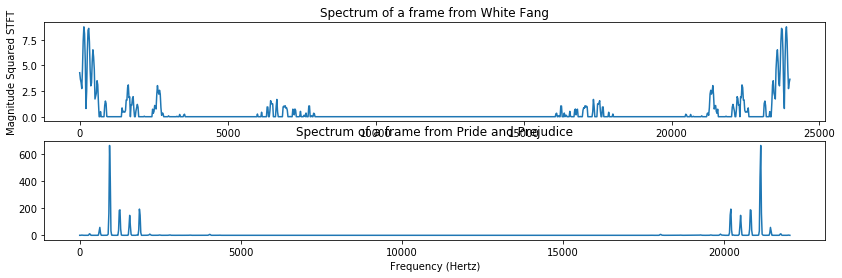

In [8]:
(w_stft, w_freqaxis) = stft(w_frames, 1024, w_fs)
(p_stft, p_freqaxis) = stft(p_frames, 1024, p_fs)
plt.figure(figsize=(14,4))
plt.subplot(211)
plt.plot(w_freqaxis,np.log(np.maximum(1,abs(w_stft[11])**2)))
plt.ylabel('Magnitude Squared STFT')
plt.title('Spectrum of a frame from White Fang')
plt.subplot(212)
plt.plot(p_freqaxis,abs(p_stft[11])**2)
plt.title('Spectrum of a frame from Pride and Prejudice')
plt.xlabel('Frequency (Hertz)')


For speech signals, we usually only care about the frequencies below about 5000Hz.  In particular, the spectrum at frequencies above $F_s/2$ (in this case, above 12kHz) are just an aliased image of the spectrum below $F_s/2$, so we remove them from the plot as shown below.

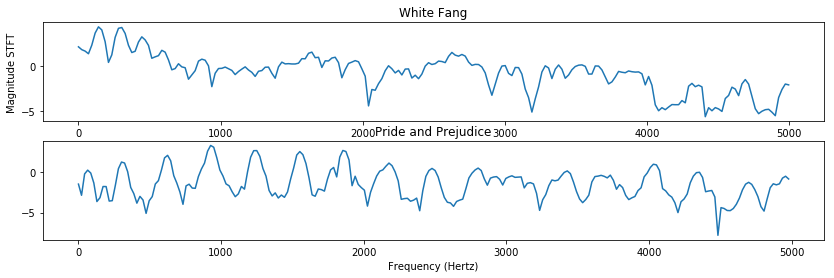

In [9]:
plt.figure(figsize=(14,4))
plt.subplot(211)
plt.plot(w_freqaxis[w_freqaxis<=5000],np.log(abs(w_stft[11][w_freqaxis<=5000])))
plt.title('White Fang')
plt.ylabel('Magnitude STFT')
plt.subplot(212)
plt.plot(p_freqaxis[p_freqaxis<=5000],np.log(abs(p_stft[11][p_freqaxis<=5000])))
plt.title('Pride and Prejudice')
plt.xlabel('Frequency (Hertz)')

### 3. Compute Level
$$Level(x) = 20\log_{10} |x| = 10\log_{10}|x|^2$$ in decibels
$$Bel(x) = \log_{10}|x|^2$$
In order to avoid getting negative infinity values, we first figure out which pixel has the highest power; then we threshold the entire array so that every value is greater than or equal to one thousandth of the highest power (60dB down); then we take the logarithm.  

Finally... every spectrum includes its own mirror image, at frequencies between Nyquist and the sampling rate.  Let's just keep the first half, up to some maximum frequency bin that we'll specify when we call the program.

In [10]:
def stft2level(stft_spectra,max_freq_bin):
    magnitude_spectra = [ abs(x) for x in stft_spectra ]
    max_magnitude = max([ max(x) for x in magnitude_spectra ])
    min_magnitude = max_magnitude / 1000.0
    for t in range(0,len(magnitude_spectra)):
        for k in range(0,len(magnitude_spectra[t])):
            magnitude_spectra[t][k] /= min_magnitude
            if magnitude_spectra[t][k] < 1:
                magnitude_spectra[t][k] = 1
    level_spectra = [ 20*np.log10(x[0:max_freq_bin]) for x in magnitude_spectra ]
    return(level_spectra)

Test it: compute the spectrograms with 25ms window and 10ms skip, and display them

22050


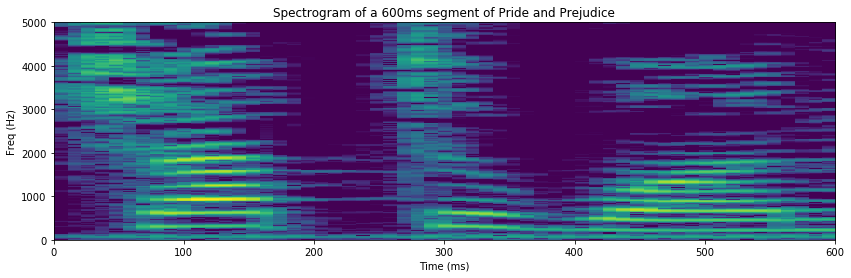

In [11]:
max_freq = 5000 # choose 5000Hz as the maximum displayed frequency
p_sgram = stft2level(p_stft, int(1024*max_freq/p_fs))
w_sgram = stft2level(w_stft,int(1024*max_freq/w_fs))
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,600,0,max_freq),aspect='auto')
plt.title('Spectrogram of a 600ms segment of Pride and Prejudice')
plt.xlabel('Time (ms)')
plt.ylabel('Freq (Hz)')
print(p_fs)

### spectrogram function

Now let's create a spectrogram function.  It will take, as input, a signal, and the parameters frame_skip, frame_length, fft_length, fs, and max_freq.  It will generate the spectrogram as output.

In [12]:
def sgram(x,frame_skip,frame_length,fft_length, fs, max_freq):
    frames = enframe(x,frame_skip,frame_length)
    (spectra, freq_axis) = stft(frames, fft_length, fs)
    sgram = stft2level(spectra, int(max_freq*fft_length/fs))
    max_time = len(frames)*frame_skip/fs
    return(sgram, max_time, max_freq)

Let's try it, by computing the same spectrogram as above, but using a 2ms frame skip instead of 10ms.

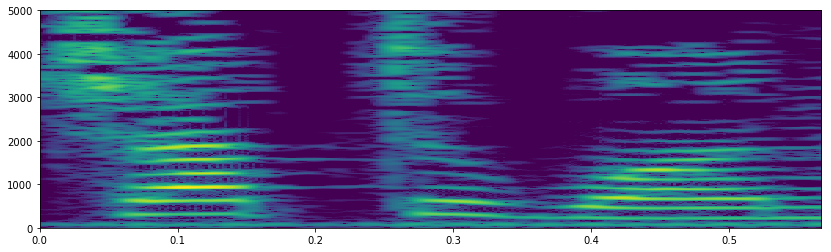

In [13]:
(p_sgram, p_maxtime, p_maxfreq) = sgram(p_wav, int(0.002*p_fs), int(0.035*p_fs), 1024, p_fs, 5000)
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,p_maxtime,0,p_maxfreq),aspect='auto')

## Speech time scales

A voiced speech signal is created when the vocal folds clap together, once every $N_0$ samples.  The "clap" of the vocal folds hitting one another causes ringing in the vocal tract.

$$x[n] = \sum_{m=-\infty}^{\infty} h[n-mN_0]$$

where $h[n]$ is the impulse response of the ringing vocal tract.  There are two important time scales in a speech signal:

* First, $T_0=N_0/F_s=1/F_0$, the pitch period ($F_s$ is the sampling frequency, in samples/second; $F_0$ is the pitch frequency, in Hertz).  In the waveform display several boxes up, you can see that the pitch period for the female speaker is about 4ms, while the pitch period for the male speaker is about 10ms.

* Second, $T_1=1/F_1$, the period of the first formant (the first resonance of the vocal tract).  You can see from the waveform display that $T_1$ for the male speaker is about 2.5ms (meaning that his first formant frequency, for this vowel, is about $1000/2.5=400$Hz), while the $T_1$ for the female speaker is about 1.5ms (meaning that her first formant frequency, for this vowel, is about $1000/1.5=667$Hz).

### Narrowband spectrogram
A narrowband spectrogram is created using a window which is longer than $2T_0$.  For example, the spectrogram above is narrowband, since $35$ms is longer than $T_0$ of the female speaker.  In a narrowband spectrogram, each individual spectral slice has harmonics of the pitch frequency.  Therefore you can estimate the pitch frequency by counting the number of harmonics below 1000Hz.  In this case, there are 4 harmonics below 1000Hz, so the pitch frequency is about $F_0=1000/4=250$Hz.   That matches, very well, the pitch period of $T_0=4$ms that we estimated before.

### Wideband spectrogram.
A wideband spectrogram is created using a window which is less than $T_0$.  For example, suppose we use a window which is only $4$ms in length.

What we will see, in this case, is that the level of the WHOLE SPECTRUM goes up or down, depending on whether there is a glottal pulse inside the window or not.  When there is a glottal pulse in the spectrum, it is bright; when not, it is dark.

The pitch frequency is therefore visible on the TIME AXIS, rather than on the FREQUENCY AXIS.  The FREQUENCY AXIS, in this case, is useful to show the formant frequencies: $F_1$, $F_2$, and so on.

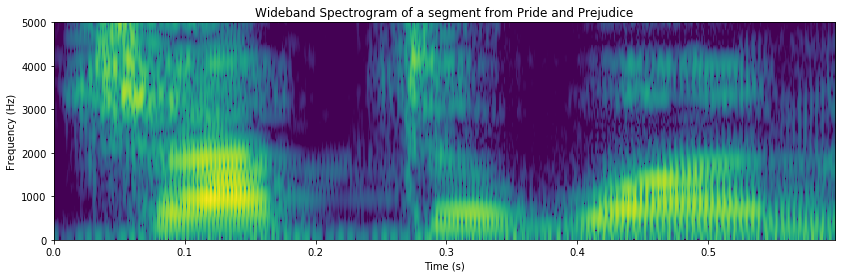

In [14]:
(p_sgram,p_maxtime, p_maxfreq) = sgram(p_wav, int(0.001*p_fs), int(0.004*p_fs), 1024, p_fs, 5000)
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(p_sgram)),origin='lower',extent=(0,p_maxtime,0,p_maxfreq),aspect='auto')
plt.title('Wideband Spectrogram of a segment from Pride and Prejudice')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

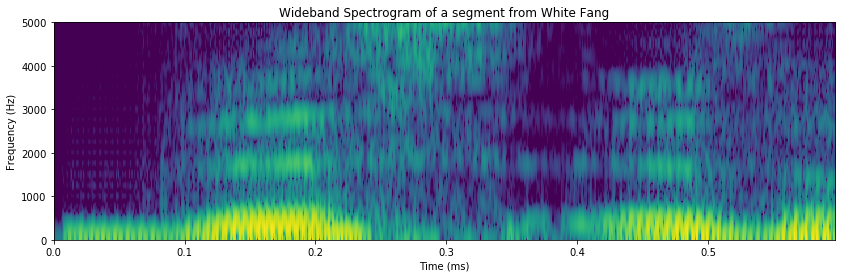

In [15]:
(w_sgram, w_maxtime, w_maxfreq) = sgram(w_wav, int(0.001*w_fs), int(0.004*w_fs), 1024, w_fs, 5000)  
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(w_sgram)),origin='lower',extent=(0,w_maxtime,0,w_maxfreq),aspect='auto')
plt.title('Wideband Spectrogram of a segment from White Fang')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

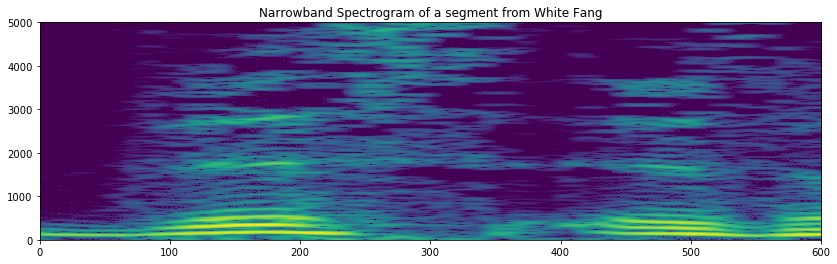

In [16]:
(narrowband_w_sgram,w_maxtime,w_maxfreq) = sgram(w_wav, int(0.001*w_fs), int(0.035*w_fs), 1024, w_fs, 5000)
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(narrowband_w_sgram)),origin='lower',extent=(0,600,0,5000),aspect='auto')
plt.title('Narrowband Spectrogram of a segment from White Fang')

## Appendix: Why Wideband versus Narrowband?
Now I want to focus more on the formula for the STFT, $$X_t(f)=\sum_{n=0}^{L-1} x_t[n]e^{-j2\pi fn/F_s}$$

Remember that $e^{j\theta}=\cos\theta + j\sin\theta$.  So the STFT has a real part, and an imaginary part:
$$X_t(f) = \sum_{n=0}^{L-1} x[n+tS] w[n] \cos\left(\frac{2\pi n f}{F_s}\right) + j\sum_{n=0}^{L-1} x[n+tS]w[n] \sin\left(\frac{2\pi n f}{F_s}\right)$$

Now let's consider the special case when the input is also a cosine, i.e., $x[n+tS]=\cos(2\pi F n/F_s)$, for some frequency $F$.  Let's compute the real part of $X_t(f)$ for different values of $\psi$:
$$\Re\left\{X_t(f)\right\}=\sum_{n=0}^{L-1}\cos\left(\frac{2\pi nF}{F_s}\right)w[n]\cos\left(\frac{2\pi n f}{F_s}\right)$$
You should discover that, when $f=F$ exactly, $\Re\left\{X_t(f)\right\}$ is large.  When $f\approx F$, $\Re\left\{X_t(f)\right\}$ gets a little bit smaller, until it goes to zero exactly when $f = F\pm \frac{2F_s}{L}$.

So, in exactly this sense, the BANDWIDTH of analysis is $\frac{2F_s}{L}$: when the frequency of the input signal is different from the spectral bin by exactly $\frac{2F_s}{L}$, then the spectrum at that point goes to zero.  

The duration of the window, in seconds, is $$T_W=\frac{L}{F_s}$$
So the bandwidth of analysis is $$B_W=\frac{2}{T_W}$$  For example, a window of duration $T_W=0.02$ seconds has an analysis bandwidth of $B_W=\frac{2}{0.02}=100$Hz, meaning that a 20ms Hamming window smears the spectrogram in the frequency domain by about +/-100Hz. A window of length 0.006 seconds has an analysis bandwidth of $B_W=\frac{2}{0.006}=333$Hz, meaning that a 6ms Hamming window smears the spectrogram in the frequency domain by about +/- 333Hz.


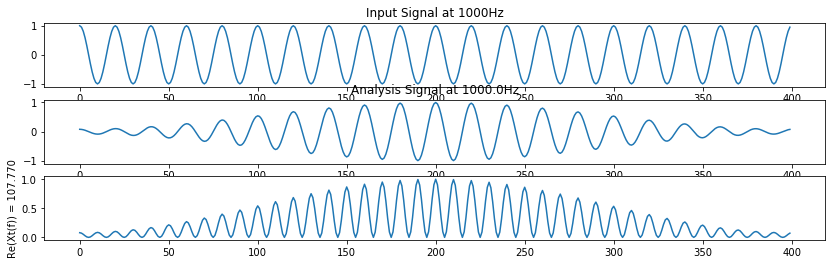

In [17]:
window_duration = 0.02
input_frequency = 1000
analysis_frequency = 1000+0/window_duration
sampling_frequency = 20000
window_length = int(window_duration * sampling_frequency)
input_signal = np.array([ math.cos(2*math.pi*n*input_frequency/sampling_frequency) for n in range(0,window_length) ])
hamming_window = np.hamming(window_length)
analysis_signal = np.array([ math.cos(2*math.pi*n*analysis_frequency/sampling_frequency)*hamming_window[n] for n in range(0,window_length)])
plt.figure(figsize=(14,4))
plt.subplot(311)
plt.plot(input_signal)
plt.title('Input Signal at {}Hz'.format(input_frequency))
plt.subplot(312)
plt.plot(analysis_signal)
plt.title('Analysis Signal at {}Hz'.format(analysis_frequency))
plt.subplot(313)
plt.plot(analysis_signal*input_signal)
real_part_of_stft = sum(analysis_signal*input_signal)
plt.ylabel('Re(Xt(f)) = {0:.3f}'.format(real_part_of_stft))